In [1]:
# %matplotlib widget

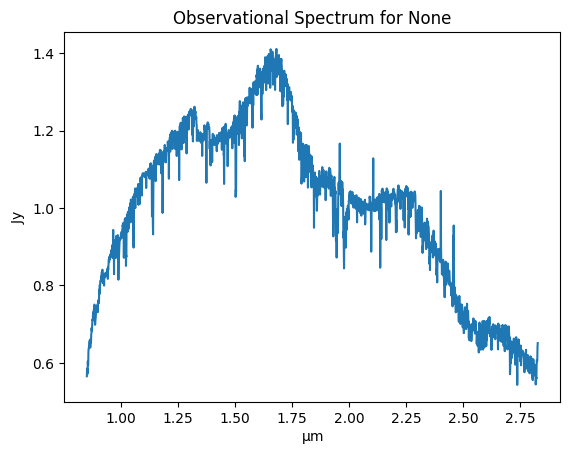

<spectrum name=None len=2048 unit=Jy>
reading in hdf5
finished reading in hdf5
[0.01550574 0.01965951 0.02381982 ... 0.48200772 0.48158238 0.47929856] Jy


In [ ]:
# for now, just request a random composite spectrum from facula_and_spot_creator
# and try to decompose it - aka can we regenerate the w's

# eventually can read in external data or some training data from a large hdf5 file etc

from itertools import product
from pathlib import Path
import astropy
from astropy.table import QTable
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import scipy as sp
from astropy.visualization import quantity_support
quantity_support()
from tqdm import tqdm
import astropy.units as u
from scipy.interpolate import interp1d
from astropy.units import Quantity
from joblib import Parallel, delayed
import os

from spots_and_faculae_model.spectrum import spectrum
from src.spectrum_component_analyser.internals.readers import read_JWST_fits
from spots_and_faculae_model.spectral_grid import spectral_grid
from spectrum_component_analyser.helper import calc_result, get_optimality, plot_nicely, get_main_components

external_spectrum_path = Path("../../assets/MAST_2025-10-26T11_57_04.058Z - LTT-3780/MAST_2025-10-26T11_57_04.058Z/JWST/jw03557004001_04101_00001-seg001_nis_x1dints.fits")
script_dir = os.getcwd()  # usually the folder where notebook is running")
wavelength_grid_absolute_path = (script_dir / external_spectrum_path).resolve()

spectrum_to_decompose : spectrum = read_JWST_fits(wavelength_grid_absolute_path, INTEGRATION_INDEX=100)
spectrum_to_decompose.plot()
print(spectrum_to_decompose)

mask = np.isfinite(spectrum_to_decompose.Fluxes)

spectrum_to_decompose = spectrum_to_decompose[mask]

print("reading in hdf5")
spectral_grid_relative_path = Path("../../assets/JWST_convolved_spectral_grid.hdf5")
spectral_grid_absolute_path = (script_dir / spectral_grid_relative_path).resolve()
spec_grid : spectral_grid = spectral_grid.from_hdf5(absolute_path=spectral_grid_absolute_path)
lookup_table = spec_grid.to_lookup_table()
print("finished reading in hdf5")

print(lookup_table[2500 *u.K, 0.0 * u.dimensionless_unscaled, 0.0 * u.dimensionless_unscaled])

In [3]:
from typing import Tuple

all_parameters = list(product(spec_grid.T_effs, spec_grid.FeHs, spec_grid.Log_gs))

total_number_of_components = len(spec_grid.T_effs) * len(spec_grid.FeHs) * len(spec_grid.Log_gs)

A, result = calc_result(all_parameters, lookup_table, spec_grid=spec_grid, spectrum_to_decompose=spectrum_to_decompose, mask=mask, total_number_of_components=total_number_of_components)
print(f"residual MSE = {get_optimality(A, result, spectrum_to_decompose)}")

Appending values to A matrix...: 100%|██████████| 2106/2106 [00:01<00:00, 1607.36it/s]


minimising
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         1.3416e+09                                    6.36e+06    
       1         3.3510e+08      1.01e+09       1.31e+01       1.59e+06    
       2         8.3626e+07      2.51e+08       6.54e+00       3.98e+05    
       3         2.0832e+07      6.28e+07       3.27e+00       9.94e+04    
       4         5.1710e+06      1.57e+07       1.63e+00       2.48e+04    
       5         1.2744e+06      3.90e+06       8.17e-01       6.21e+03    
       6         3.0960e+05      9.65e+05       4.08e-01       1.55e+03    
       7         7.3059e+04      2.37e+05       2.04e-01       3.88e+02    
       8         1.6248e+04      5.68e+04       1.02e-01       9.67e+01    
       9         3.1954e+03      1.31e+04       5.06e-02       2.39e+01    
      10         4.8353e+02      2.71e+03       2.47e-02       5.71e+00    
      11         4.2224e+01      4.41e+02       1.11e-02       1.22e+00    
 

/home/bengreen/University/Part III/stellar-heterogeneity-modelling/spots_and_faculae_model/src/spectrum_component_analyser/helper.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


     T_eff / K Fe/H / relative to solar log_g / log(cm s^(-2))  weight
1611  3600.0 K                      0.0                    6.0   0.455
1637  3600.0 K                      1.0                    6.0   0.141
2014  4000.0 K                     -3.0                    6.0   0.089
1989  4000.0 K                     -4.0                    0.0   0.081
1164  3200.0 K                      1.0                    3.5   0.060
418   2600.0 K                     -0.5                    1.0   0.056
1284  3300.0 K                      1.0                    5.0   0.039
425   2600.0 K                     -0.5                    4.5   0.033
40    2300.0 K                     -1.5                    0.5   0.032
54    2300.0 K                     -1.0                    1.0   0.000


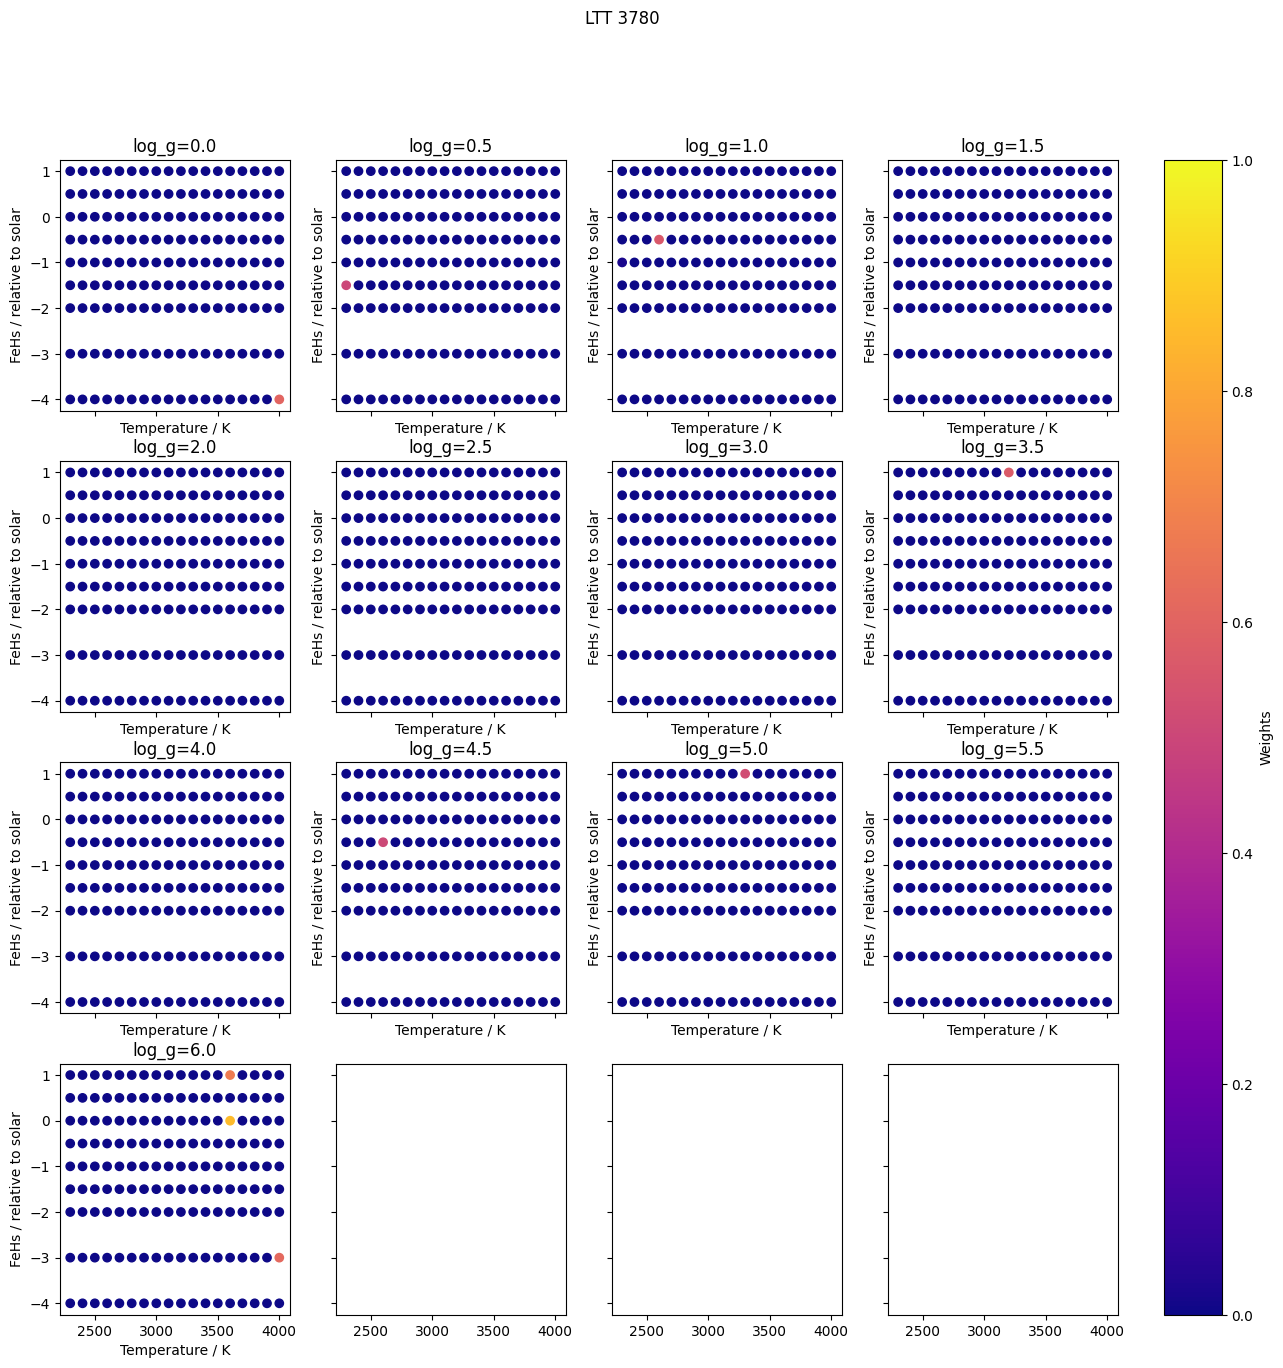

<Figure size 640x480 with 0 Axes>

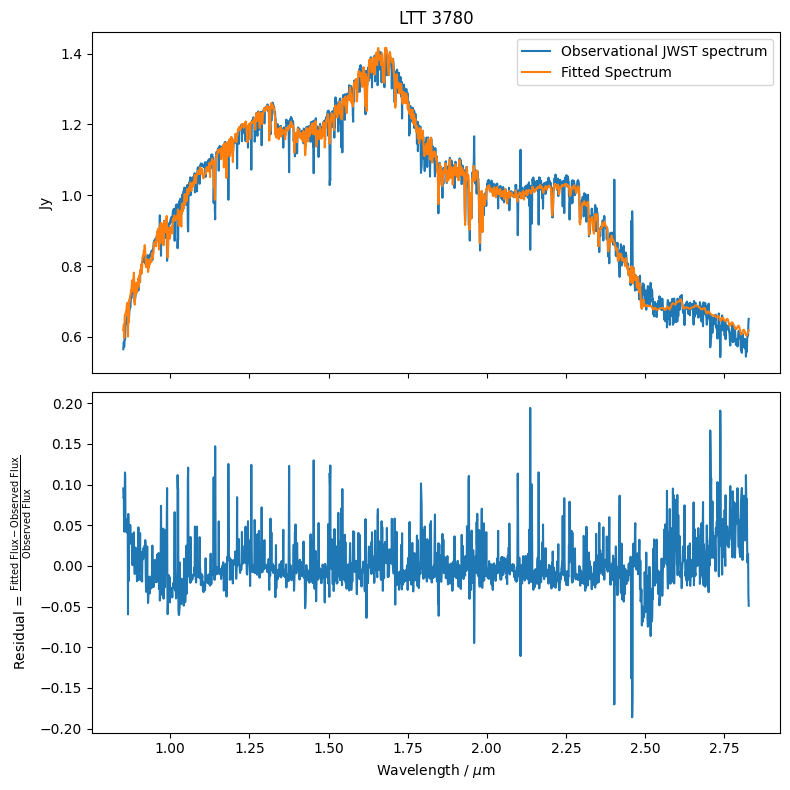

In [4]:

hash_map = plot_nicely(A, result, all_parameters, spec_grid, spectrum_to_decompose)

100%|██████████| 19/19 [00:00<00:00, 49.34it/s]


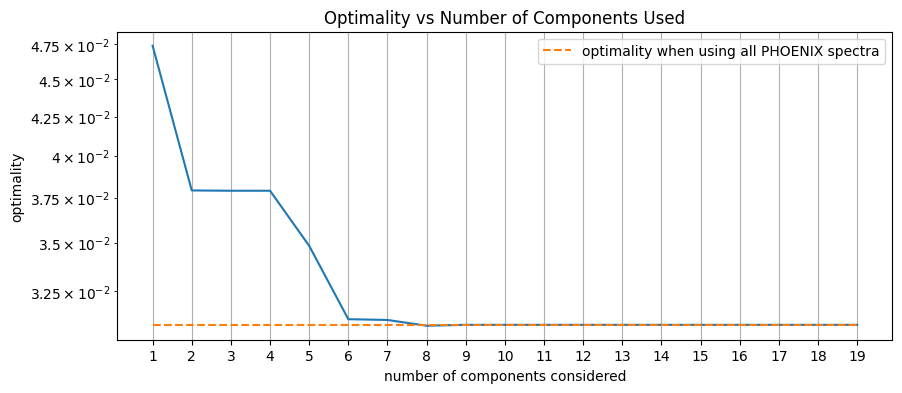

In [5]:
# now lets re-run that, but with only the top few components and see if the fit is better

# prolly want a new class for this lmao
# or could be a list of phoenix spectra; maybe that would help the above code be a bit neater too

ns = np.arange(1, 20, 1)
optimalities = np.array([])

for number_of_components_to_keep in tqdm(ns):
    
    main_components = get_main_components(hash_map, number_of_components_to_keep)

    A_restricted, result_restricted = calc_result(main_components,
                                                  lookup_table,
                                                  spectrum_to_decompose=spectrum_to_decompose,
                                                  spec_grid = spec_grid,
                                                  mask=mask,
                                                  total_number_of_components=len(main_components),
                                                  verbose=False)

    optimalities = np.append(optimalities, get_optimality(A_restricted, result_restricted, spectrum_to_decompose)[0])

# plt.clf()
plt.figure(figsize=(10,4))
plt.semilogy(ns, optimalities)
plt.semilogy(ns, [get_optimality(A, result, spectrum_to_decompose)[0]] * len(ns), linestyle="dashed", label="optimality when using all PHOENIX spectra")
plt.xticks(ns)
plt.grid()
plt.legend()
plt.xlabel("number of components considered")
plt.ylabel("optimality")  #of matrix minimisation method (lower is more optimal)
plt.title(f"Optimality vs Number of Components Used")
plt.show()

Residual MSE = 0.031090668588539098
  T_eff / K Fe/H / relative to solar log_g / log(cm s^(-2))  weight
0  3600.0 K                      0.0                    6.0   0.572
6  3300.0 K                      1.0                    5.0   0.168
5  2600.0 K                     -0.5                    1.0   0.088
2  4000.0 K                     -3.0                    6.0   0.083
3  4000.0 K                     -4.0                    0.0   0.045
4  3200.0 K                      1.0                    3.5   0.029
1  3600.0 K                      1.0                    6.0   0.000


/home/bengreen/University/Part III/stellar-heterogeneity-modelling/spots_and_faculae_model/src/spectrum_component_analyser/helper.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hash_map = pd.concat([hash_map, pd.DataFrame([new_row])], ignore_index=True)


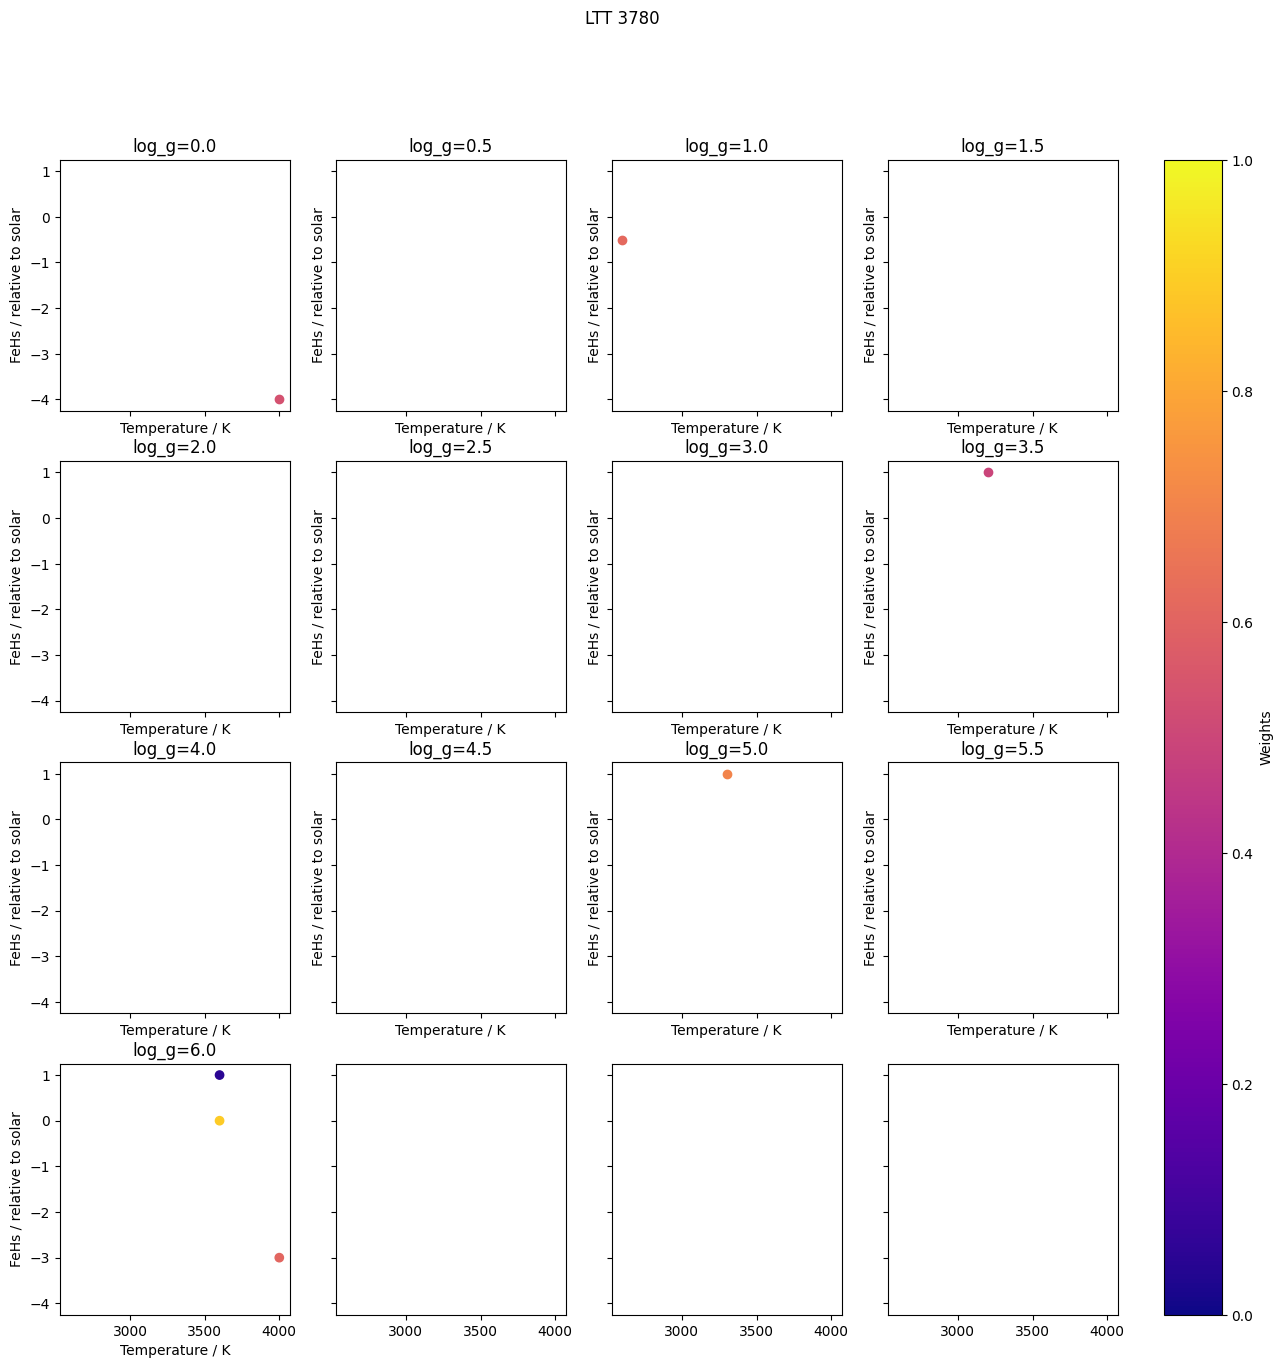

<Figure size 640x480 with 0 Axes>

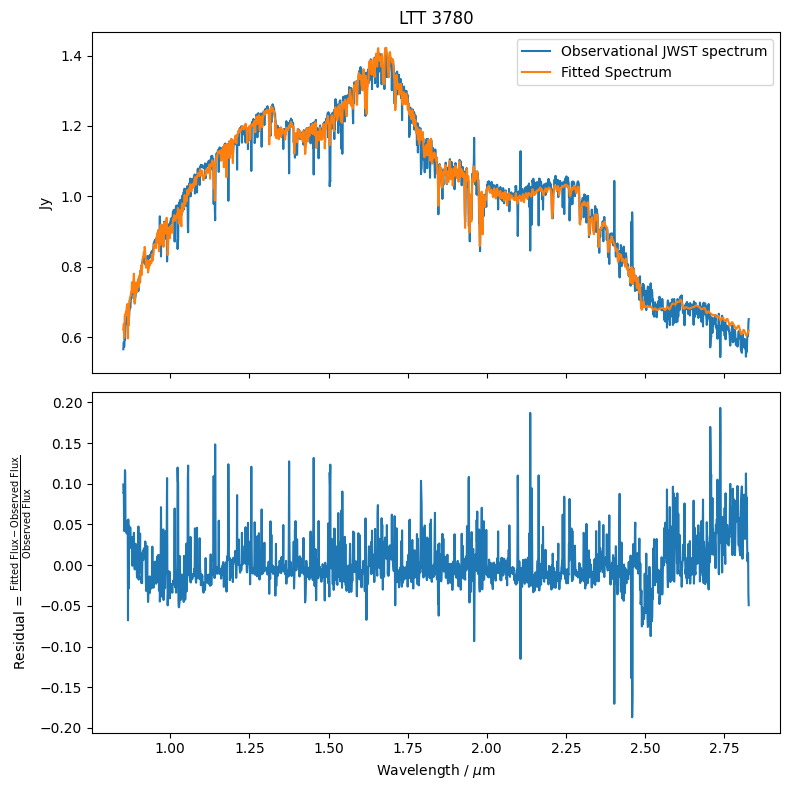

In [6]:
main_components = get_main_components(hash_map, 7)

shifted_lookup_table = {k: v.copy() for k, v in lookup_table.items()}

for key, flux in shifted_lookup_table.items():
    flux[:] = np.roll(flux, 0) # need the [:] for in place modification i.e. to change the reference

A_restricted, result_restricted = calc_result(main_components,
                                              shifted_lookup_table,
                                              spectrum_to_decompose=spectrum_to_decompose,
                                              spec_grid=spec_grid,
                                              mask=mask,
                                              total_number_of_components=len(main_components),
                                              verbose=False)

print(f"Residual MSE = {get_optimality(A_restricted, result_restricted, spectrum_to_decompose)[0]}")

_ = plot_nicely(A_restricted, result_restricted, main_components, spec_grid, spectrum_to_decompose)

100%|██████████| 19/19 [00:00<00:00, 20.10it/s]


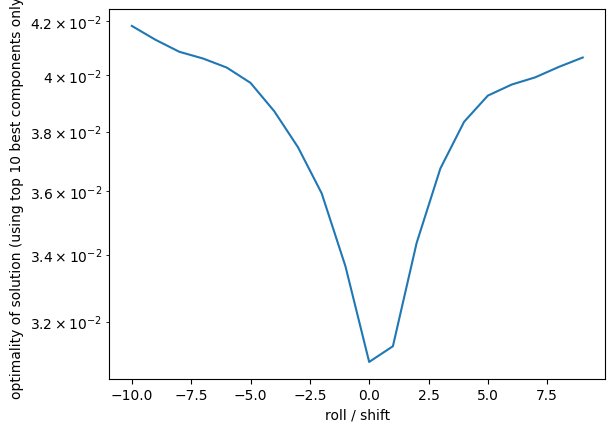

In [7]:
# can try another meta-optimiser: shift the spectrum between [-20,+20] or smthn resolutions to the left & right
# there might be some small zero error on the phoenix grid or smthn (I wouldn't be suprised) - this would help check for that

# from experimenting: no rolling is best
main_comps = get_main_components(hash_map, 10)

optimalities = []

# independent copy - we dont want the shift to affect the original lookup_table
shifted_lookup_table = {k: v.copy() for k, v in lookup_table.items()}

shifts = np.arange(-10,10,1)

for key, flux in shifted_lookup_table.items():
    flux[:] = np.roll(flux, np.min(shifts)) # need the [:] for in place modification i.e. to change the reference

A, result = calc_result(main_comps,
                        shifted_lookup_table,
                        spectrum_to_decompose=spectrum_to_decompose,
                        spec_grid=spec_grid,
                        mask=mask,
                        total_number_of_components=len(main_comps),
                        verbose=False)

optimalities.append(get_optimality(A, result, spectrum_to_decompose)[0])

positive_shifts = shifts + np.abs(np.min(shifts))

for shift in tqdm(positive_shifts[0:-1]):
    for key, flux in shifted_lookup_table.items():
        flux[:] = np.roll(flux, 1) # need the [:] for in place modification i.e. to change the reference
    A, result = calc_result(main_comps,
                            shifted_lookup_table,
                            spectrum_to_decompose=spectrum_to_decompose,
                            spec_grid=spec_grid,
                            mask=mask,
                            total_number_of_components=len(main_comps),
                            verbose=False)
    optimalities.append(get_optimality(A, result, spectrum_to_decompose)[0])

    # plot_nicely(A, result, main_comps)

plt.clf()
plt.semilogy(shifts, optimalities)
plt.xlabel("roll / shift")
plt.ylabel("optimality of solution (using top 10 best components only)")
plt.show()

# now we can fit in sections too

# can also interpolate in different ways

# also can visualise other spectra; see what works

# also can use other spectra from lalitha